In [ ]:
!unzip dataset50.zip

In [70]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [71]:
!mkdir -p saved_model

In [ ]:
!pip install tensorflow~=2.3.0 tensorflow_gcs_config~=2.3.0
import tensorflow as tf
import requests
import os
resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
if resp.status_code != 200:
  print("Failed to switch the TPU to TF {}".format(version))

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, applications, optimizers, activations
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
tf.__version__

'2.5.0'

# TPU Setup

In [3]:
assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

tpu_address = TF_MASTER

In [4]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
print("Number of devices: ", len(tf.config.list_logical_devices('TPU')))

INFO:tensorflow:Initializing the TPU system: grpc://10.120.128.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.120.128.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
Number of devices:  8


In [5]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Utils

In [6]:
def load_dataset(size):
  if size == 100:

    cm = [x for x in os.walk('CM100')][0][2]
    hs = [x for x in os.walk('HS100')][0][2]
    hc = [x for x in os.walk('HC100')][0][2]

  elif size == 200:
    cm = [x for x in os.walk('CM200')][0][2]
    hs = [x for x in os.walk('HS200')][0][2]
    hc = [x for x in os.walk('HC200')][0][2]
  
  elif size == 224:
    cm = [x for x in os.walk('CM224')][0][2]
    hs = [x for x in os.walk('HS224')][0][2]
    hc = [x for x in os.walk('HC224')][0][2]
  
  elif size == 50:
    cm = [x for x in os.walk('CM50')][0][2]
    hs = [x for x in os.walk('HS50')][0][2]
    hc = [x for x in os.walk('HC50')][0][2]
  
  else:
    return 'invalid size'
  
  cm = ['CM50/' + cm[x] for x in range(len(cm))]
  hs = ['HS50/' + hs[x] for x in range(len(hs))]
  hc = ['HC50/' + hc[x] for x in range(len(hc))]
  
  cm_label = [0]*len(cm)
  hs_label = [1]*len(hs)
  hc_label = [2]*len(hc)

  dataset = cm+hs+hc
  labels = cm_label + hs_label + hc_label

  return dataset, labels

In [7]:
def read_images(dataset):
  images = []
  
  for filepath in dataset:
    images.append(cv2.imread(filepath))
  
  return images

In [8]:
dataset, labels = load_dataset(50)

In [ ]:
print(labels.count(0), labels.count(1), labels.count(2))
print(len(dataset))

In [9]:
dataset = read_images(dataset)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=37)

In [11]:
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
len(y_train) - np.count_nonzero(y_train) # 397, 27.6%
# np.count_nonzero(y_train==1) # 365, 30%
# np.count_nonzero(y_train==2) # 334, 32.8%

352

In [ ]:
X_train.shape

(1050, 50, 50, 3)

In [ ]:
X_train[0]

array([[[0.4745098 , 0.56470588, 0.8627451 ],
        [0.43137255, 0.52156863, 0.81568627],
        [0.47843137, 0.56078431, 0.85490196],
        ...,
        [0.38823529, 0.53333333, 0.7372549 ],
        [0.38823529, 0.55294118, 0.69803922],
        [0.34901961, 0.52156863, 0.64313725]],

       [[0.56078431, 0.65882353, 0.94901961],
        [0.50588235, 0.60392157, 0.89411765],
        [0.52941176, 0.62352941, 0.90588235],
        ...,
        [0.29803922, 0.44313725, 0.64705882],
        [0.3372549 , 0.49803922, 0.65098039],
        [0.30588235, 0.4745098 , 0.60392157]],

       [[0.51764706, 0.63921569, 0.90980392],
        [0.46666667, 0.58823529, 0.85882353],
        [0.48627451, 0.6       , 0.8627451 ],
        ...,
        [0.23137255, 0.37254902, 0.58431373],
        [0.25098039, 0.40784314, 0.57254902],
        [0.22745098, 0.39215686, 0.52941176]],

       ...,

       [[0.3254902 , 0.43921569, 0.67843137],
        [0.48235294, 0.59607843, 0.83529412],
        [0.61176471, 0

In [ ]:
y_train, y_test = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)

# Define Model

In [124]:
def create_model():
  return tf.keras.Sequential(
        [
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)),
        layers.Dropout(0.2),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
         
        layers.MaxPooling2D((5,5)),
        layers.Dropout(0.65),

        layers.Flatten(),
        
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.03)),
        layers.LeakyReLU(0.01),
        layers.Dropout(0.25),
        
        layers.Dense(256, kernel_regularizer=regularizers.l2(0.03)),
        layers.LeakyReLU(0.01),
        layers.Dropout(0.25),
        
        layers.BatchNormalization(momentum=0.5),
        
        layers.Dense(128, kernel_regularizer=regularizers.l2(0.02)),
        layers.LeakyReLU(0.01),
        layers.Dropout(0.25),
        
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.02)),
        layers.LeakyReLU(0.01),
        layers.Dropout(0.25),
         
        layers.Dense(32, kernel_regularizer=regularizers.l2(0.02)),
        layers.LeakyReLU(0.01),
        layers.Dropout(0.25),
        
        layers.Dense(3, activation='softmax')
    ])

In [47]:
def create_model():
  return tf.keras.Sequential(
      [tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=(50, 50, 3)),
       tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
       tf.keras.layers.MaxPooling2D(),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(256),
       tf.keras.layers.LeakyReLU(0.1),
       tf.keras.layers.Dense(128),
       tf.keras.layers.LeakyReLU(0.1),
       tf.keras.layers.Dense(3, activation= 'softmax')
       ])

In [136]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_sparse_categorical_accuracy') >= 0.895:
            self.model.stop_training = True

callback = CustomCallback()

In [137]:
with strategy.scope():
  cnn = create_model()
  cnn.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])
  
cnn.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 48, 48, 256)       7168      
_________________________________________________________________
dropout_133 (Dropout)        (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 46, 46, 128)       295040    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
dropout_134 (Dropout)        (None, 9, 9, 128)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 10368)             0         
_________________________________________________________________
dense_111 (Dense)            (None, 512)             

In [138]:
cnn_history = cnn.fit(X_train, y_train, epochs=250, batch_size=64, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/250
 4/17 [======>.......................] - ETA: 0s - loss: 44.7951 - sparse_categorical_accuracy: 0.3320  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0027s vs `on_train_batch_end` time: 0.6538s). Check your callbacks.


17/17 [==============================] - 14s 432ms/step - loss: 36.2506 - sparse_categorical_accuracy: 0.3400 - val_loss: 25.1549 - val_sparse_categorical_accuracy: 0.3333
Epoch 2/250
17/17 [==============================] - 1s 50ms/step - loss: 19.9654 - sparse_categorical_accuracy: 0.3486 - val_loss: 15.1637 - val_sparse_categorical_accuracy: 0.3356
Epoch 3/250
17/17 [==============================] - 1s 49ms/step - loss: 12.7145 - sparse_categorical_accuracy: 0.3238 - val_loss: 10.2469 - val_sparse_categorical_accuracy: 0.3578
Epoch 4/250
17/17 [==============================] - 1s 49ms/step - loss: 8.8814 - sparse_categorical_accuracy: 0.3486 - val_loss: 7.4880 - val_sparse_categorical_accuracy: 0.3622
Epoch 5/250
17/17 [==============================] - 1s 89ms/step - loss: 6.6675 - sparse_categorical_accuracy: 0.3343 - val_loss: 5.7920 - val_sparse_categorical_accuracy: 0.3556
Epoch 6/250
17/17 [==============================] - 1s 50ms/step - loss: 5.2491 - sparse_categorical_ac

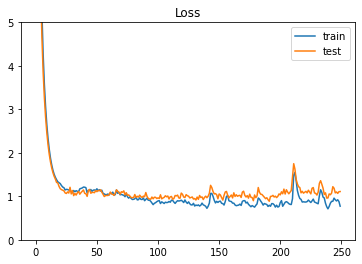

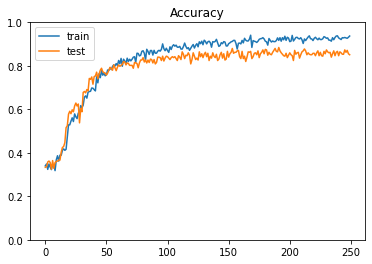

In [139]:
#plotting loss graph
plt.figure()
plt.title('Loss')
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.legend(['train', 'test'])
plt.ylim([0, 5])
plt.show()

#plotting accuracy graph
plt.figure()
plt.title('Accuracy')
plt.plot(cnn_history.history['sparse_categorical_accuracy'])
plt.plot(cnn_history.history['val_sparse_categorical_accuracy'])
plt.legend(['train', 'test'])
plt.ylim([0, 1])
plt.show()

In [140]:
predictions = cnn.predict(X_test) # softmax probabilities
round_pred = np.round(predictions) # one-hot encoding

In [141]:
simp_pred = tf.argmax(round_pred, axis = 1)
# simp_labels = tf.argmax(y_test, axis = 1) # use only if one-hot encoded

In [142]:
confusion_matrix = tf.math.confusion_matrix(y_test, simp_pred, num_classes=3)

In [143]:
print(confusion_matrix)
'''
cm = 0
hs = 1
hc = 2
'''

tf.Tensor(
[[104  16  21]
 [  9 135   9]
 [  3  12 141]], shape=(3, 3), dtype=int32)


'\ncm = 0\nhs = 1\nhc = 2\n'

In [144]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, simp_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, simp_pred, labels=[0,1,2], average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, simp_pred, labels=[0,1,2], average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, simp_pred, labels=[0,1,2], average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.844444
Precision: 0.849778
Recall: 0.841263
F1 score: 0.842051
